In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean #A package with beautiful colormaps
import cartopy #Useful for plotting maps
import cartopy.util #Requires separate import
import cartopy.crs as ccrs
import pandas as pd
from scipy import stats
from math import cos,radians
import copy

plot_path = '/home/u/u241308/figures/'

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
#--------------------- select location ---------------------
location = 'Europe'
#location = 'North_America'
#location = 'Asia'

In [3]:
#--------------------- select HW parameters ---------------------
# Consecutive days for heatwave detection
c_days = 6

# Threshold percentile
percentile = 90 #95

#Definition type: daily moving threshold (mov_day) or JA moving threshold (mov_JA)
def_type = 'fix_day'

ref_min = 1985
ref_max = 2014

In [4]:
def change_lon(data1,shape):
    data1['lon'] = np.where(data1.lon >180, data1.lon-360,data1.lon)
    ind = np.argsort(data1.lon)
    ind.values
    if shape == 3:
        data1 = data1[:,:,ind.values]
    if shape == 2:
        data1 = data1[:,ind.values]
    return(data1)

# Load MPI

In [5]:
ref_hist_min = 1850
ref_hist_max = 1879

In [6]:
#Historical
path = '/work/uo1075/u241308/grand_ensemble_cmip6/tas/ens1_30/' #first 30 members
file = 'nGE_GMT_HIST_ym.nc'
GMT_hist_1 = xr.open_dataset(path+file)
GMT_hist_1 = GMT_hist_1.tas

path = '/work/uo1075/u241308/grand_ensemble_cmip6/tas/ens31_50/' #second 20 members
file = 'nGE_GMT_HIST_ym.nc'
GMT_hist_2 = xr.open_dataset(path+file)
GMT_hist_2 = GMT_hist_2.tas

GMT_hist = xr.concat((GMT_hist_1,GMT_hist_2),'height') #concatenate 50 members
GMT_hist_mean = GMT_hist.mean(axis=(1,2,3)) #average over ensemble members and lon/lat (non existent)

GMT_ref = GMT_hist_mean[(GMT_hist_mean.time.dt.year>=ref_hist_min)&(GMT_hist_mean.time.dt.year<=ref_hist_max)].mean()

#ssp245
path = '/work/uo1075/u241308/grand_ensemble_cmip6/tas/ens1_30/' #first 30 members
file = 'nGE_GMT_ssp245_ym.nc'
GMT_ssp245_1 = xr.open_dataset(path+file)
GMT_ssp245_1 = GMT_ssp245_1.tas

path = '/work/uo1075/u241308/grand_ensemble_cmip6/tas/ens31_50/' #second 20 members
file = 'nGE_GMT_ssp245_ym.nc'
GMT_ssp245_2 = xr.open_dataset(path+file)
GMT_ssp245_2 = GMT_ssp245_2.tas

GMT_ssp245 = xr.concat((GMT_ssp245_1,GMT_ssp245_2),'height') #concatenate 50 members
GMT_ssp245_mean = GMT_ssp245.mean(axis=(1,2,3)) #average over ensemble members and lon/lat (non existent)

#ssp585
path = '/work/uo1075/u241308/grand_ensemble_cmip6/tas/ens1_30/' #first 30 members
file = 'nGE_GMT_ssp585_ym.nc'
GMT_ssp585_1 = xr.open_dataset(path+file)
GMT_ssp585_1 = GMT_ssp585_1.tas

path = '/work/uo1075/u241308/grand_ensemble_cmip6/tas/ens31_50/' #second 20 members
file = 'nGE_GMT_ssp585_ym.nc'
GMT_ssp585_2 = xr.open_dataset(path+file)
GMT_ssp585_2 = GMT_ssp585_2.tas

GMT_ssp585 = xr.concat((GMT_ssp585_1,GMT_ssp585_2),'height') #concatenate 50 members
GMT_ssp585_mean = GMT_ssp585.mean(axis=(1,2,3)) #average over ensemble members and lon/lat (non existent)

#compute anomalies for ensemble mean
GMTA_hist_mean = GMT_hist_mean - GMT_ref
GMTA_ssp245_mean = GMT_ssp245_mean - GMT_ref
GMTA_ssp585_mean = GMT_ssp585_mean - GMT_ref

x_joker_GMTA = np.concatenate((GMTA_ssp245_mean,GMTA_ssp585_mean))

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [7]:
# Detrended data

ens = 50
#ssp245
years_ssp245 = np.arange(2015,2101)
hw_exceed_ssp245_gp = np.zeros((ens,years_ssp245.shape[0],19,22))

path = '/work/uo1075/u241308/data_python_PostDoc/HW_expansion/anomaly/MPI_GE/ssp245/'
for n_ens in range(ens):
    file = 'hw_exceedance_all_HW_%id'%c_days +'_%s'%percentile+ '_' + def_type + '_GE_ssp245_ref_%i'%ref_min + '-%i'%ref_max + '_JJA_'+location+'_ensemble_%i_anomaly_detrend.npy'%n_ens
    hw_exceed_ssp245_gp[n_ens,:] = np.load(path+file)
hw_exceed_ssp245_std_gp = np.nanstd(hw_exceed_ssp245_gp,axis=0)
hw_exceed_ssp245_mean_gp = np.nanmean(hw_exceed_ssp245_gp,axis=0)

#ssp585
years_ssp585 = np.arange(2015,2101)
hw_exceed_ssp585_gp = np.zeros((ens,years_ssp585.shape[0],19,22))

path = '/work/uo1075/u241308/data_python_PostDoc/HW_expansion/anomaly/MPI_GE/ssp585/'
for n_ens in range(ens):
    file = 'hw_exceedance_all_HW_%id'%c_days +'_%s'%percentile+ '_' + def_type + '_GE_ssp585_ref_%i'%ref_min + '-%i'%ref_max + '_JJA_'+location+'_ensemble_%i_anomaly_detrend.npy'%n_ens
    hw_exceed_ssp585_gp[n_ens,:] = np.load(path+file)
hw_exceed_ssp585_std_gp = np.nanstd(hw_exceed_ssp585_gp,axis=0)
hw_exceed_ssp585_mean_gp = np.nanmean(hw_exceed_ssp585_gp,axis=0)

y_joker_exceed_std_gp = np.concatenate((hw_exceed_ssp245_std_gp,hw_exceed_ssp585_std_gp),axis=0)
y_joker_exceed_mean_gp = np.concatenate((hw_exceed_ssp245_mean_gp,hw_exceed_ssp585_mean_gp),axis=0)

from scipy.stats import linregress
lin_regres_GMTA_exceed_std_gp_detrend_mpi = np.zeros((hw_exceed_ssp245_std_gp.shape[1],hw_exceed_ssp245_std_gp.shape[2]))
lin_regres_GMTA_exceed_std_gp_pvalue_detrend_mpi = np.zeros((hw_exceed_ssp245_std_gp.shape[1],hw_exceed_ssp245_std_gp.shape[2]))
lin_regres_GMTA_exceed_mean_gp_detrend_mpi = np.zeros((hw_exceed_ssp245_std_gp.shape[1],hw_exceed_ssp245_std_gp.shape[2]))
lin_regres_GMTA_exceed_mean_gp_pvalue_detrend_mpi = np.zeros((hw_exceed_ssp245_std_gp.shape[1],hw_exceed_ssp245_std_gp.shape[2]))
for x in range(hw_exceed_ssp245_std_gp.shape[1]):
    for y in range(hw_exceed_ssp245_std_gp.shape[2]):
        lin_regres_GMTA_exceed_std_gp_detrend_mpi[x,y] = linregress(x_joker_GMTA, y_joker_exceed_std_gp[:,x,y])[0]
        lin_regres_GMTA_exceed_std_gp_pvalue_detrend_mpi[x,y] = linregress(x_joker_GMTA, y_joker_exceed_std_gp[:,x,y])[3]
        lin_regres_GMTA_exceed_mean_gp_detrend_mpi[x,y] = linregress(x_joker_GMTA, y_joker_exceed_mean_gp[:,x,y])[0]
        lin_regres_GMTA_exceed_mean_gp_pvalue_detrend_mpi[x,y] = linregress(x_joker_GMTA, y_joker_exceed_mean_gp[:,x,y])[3]

# Non-Detrended data
#ssp245
years_ssp245 = np.arange(2015,2101)
hw_exceed_ssp245_gp = np.zeros((ens,years_ssp245.shape[0],19,22))

path = '/work/uo1075/u241308/data_python_PostDoc/HW_expansion/anomaly/MPI_GE/ssp245/'
for n_ens in range(ens):
    file = 'hw_exceedance_all_HW_%id'%c_days +'_%s'%percentile+ '_' + def_type + '_GE_ssp245_ref_%i'%ref_min + '-%i'%ref_max + '_JJA_'+location+'_ensemble_%i_anomaly.npy'%n_ens
    hw_exceed_ssp245_gp[n_ens,:] = np.load(path+file)
hw_exceed_ssp245_std_gp = np.nanstd(hw_exceed_ssp245_gp,axis=0)
hw_exceed_ssp245_mean_gp = np.nanmean(hw_exceed_ssp245_gp,axis=0)

#ssp585
years_ssp585 = np.arange(2015,2101)
hw_exceed_ssp585_gp = np.zeros((ens,years_ssp585.shape[0],19,22))

path = '/work/uo1075/u241308/data_python_PostDoc/HW_expansion/anomaly/MPI_GE/ssp585/'
for n_ens in range(ens):
    file = 'hw_exceedance_all_HW_%id'%c_days +'_%s'%percentile+ '_' + def_type + '_GE_ssp585_ref_%i'%ref_min + '-%i'%ref_max + '_JJA_'+location+'_ensemble_%i_anomaly.npy'%n_ens
    hw_exceed_ssp585_gp[n_ens,:] = np.load(path+file)
hw_exceed_ssp585_std_gp = np.nanstd(hw_exceed_ssp585_gp,axis=0)
hw_exceed_ssp585_mean_gp = np.nanmean(hw_exceed_ssp585_gp,axis=0)

y_joker_exceed_std_gp = np.concatenate((hw_exceed_ssp245_std_gp,hw_exceed_ssp585_std_gp),axis=0)
y_joker_exceed_mean_gp = np.concatenate((hw_exceed_ssp245_mean_gp,hw_exceed_ssp585_mean_gp),axis=0)

from scipy.stats import linregress
lin_regres_GMTA_exceed_std_gp_mpi = np.zeros((hw_exceed_ssp245_std_gp.shape[1],hw_exceed_ssp245_std_gp.shape[2]))
lin_regres_GMTA_exceed_std_gp_pvalue_mpi = np.zeros((hw_exceed_ssp245_std_gp.shape[1],hw_exceed_ssp245_std_gp.shape[2]))
lin_regres_GMTA_exceed_mean_gp_mpi = np.zeros((hw_exceed_ssp245_std_gp.shape[1],hw_exceed_ssp245_std_gp.shape[2]))
lin_regres_GMTA_exceed_mean_gp_pvalue_mpi = np.zeros((hw_exceed_ssp245_std_gp.shape[1],hw_exceed_ssp245_std_gp.shape[2]))
for x in range(hw_exceed_ssp245_std_gp.shape[1]):
    for y in range(hw_exceed_ssp245_std_gp.shape[2]):
        lin_regres_GMTA_exceed_std_gp_mpi[x,y] = linregress(x_joker_GMTA, y_joker_exceed_std_gp[:,x,y])[0]
        lin_regres_GMTA_exceed_std_gp_pvalue_mpi[x,y] = linregress(x_joker_GMTA, y_joker_exceed_std_gp[:,x,y])[3]
        lin_regres_GMTA_exceed_mean_gp_mpi[x,y] = linregress(x_joker_GMTA, y_joker_exceed_mean_gp[:,x,y])[0]
        lin_regres_GMTA_exceed_mean_gp_pvalue_mpi[x,y] = linregress(x_joker_GMTA, y_joker_exceed_mean_gp[:,x,y])[3]

#compute ratio
lin_regres_GMTA_exceed_mean_gp_ratio_mpi = lin_regres_GMTA_exceed_mean_gp_detrend_mpi/lin_regres_GMTA_exceed_mean_gp_mpi
lin_regres_GMTA_exceed_std_ratio_mpi = lin_regres_GMTA_exceed_std_gp_detrend_mpi/lin_regres_GMTA_exceed_std_gp_mpi

/tmp/ipykernel_985128/2825004449.py:80: RuntimeWarning: invalid value encountered in divide
  lin_regres_GMTA_exceed_mean_gp_ratio_mpi = lin_regres_GMTA_exceed_mean_gp_detrend_mpi/lin_regres_GMTA_exceed_mean_gp_mpi
/tmp/ipykernel_985128/2825004449.py:81: RuntimeWarning: invalid value encountered in divide
  lin_regres_GMTA_exceed_std_ratio_mpi = lin_regres_GMTA_exceed_std_gp_detrend_mpi/lin_regres_GMTA_exceed_std_gp_mpi


# Rest of SMILES

In [8]:
ref_hist_min = 1850
ref_hist_max = 1879

In [9]:
model_list = ['MIROC6','ACCESS-ESM1-5','CanESM5']
ens_total = [50,40,50]

In [10]:
def compare_smile(model,index):
    ens = ens_total[index]

    # ------------------- Load GMT -----------------
    #Historical
    path = '/work/uo1075/u241308/SMILE/'+model+'/tas/'
    file = model+'_GMT_historical_mm.nc'
    GMT_hist = xr.open_dataset(path+file)
    GMT_hist = GMT_hist.tas
    #yearly mean
    GMT_hist = GMT_hist.resample(time='Y').mean()
    #compute mean
    GMT_hist_mean = GMT_hist.mean(axis=(1,2,3)) #average over ensemble members and lon/lat (non existent)
    GMT_ref = GMT_hist_mean[(GMT_hist_mean.time.dt.year>=ref_hist_min)&(GMT_hist_mean.time.dt.year<=ref_hist_max)].mean()
    
    #ssp245
    path = '/work/uo1075/u241308/SMILE/'+model+'/tas/' 
    file = model+'_GMT_ssp245_mm.nc'
    GMT_ssp245 = xr.open_dataset(path+file)
    GMT_ssp245 = GMT_ssp245.tas
    #yearly mean
    GMT_ssp245 = GMT_ssp245.resample(time='Y').mean()
    #compute mean
    GMT_ssp245_mean = GMT_ssp245.mean(axis=(1,2,3)) #average over ensemble members and lon/lat (non existent)
    
    #ssp585
    path = '/work/uo1075/u241308/SMILE/'+model+'/tas/'
    file = model+'_GMT_ssp585_mm.nc'
    GMT_ssp585 = xr.open_dataset(path+file)
    GMT_ssp585 = GMT_ssp585.tas
    #yearly mean
    GMT_ssp585 = GMT_ssp585.resample(time='Y').mean()
    #compute mean
    GMT_ssp585_mean = GMT_ssp585.mean(axis=(1,2,3)) #average over ensemble members and lon/lat (non existent)
    
    #compute anomalies for ensemble mean
    GMTA_historical_mean = GMT_hist_mean - GMT_ref
    GMTA_ssp245_mean = GMT_ssp245_mean - GMT_ref
    GMTA_ssp585_mean = GMT_ssp585_mean - GMT_ref

    x_joker_GMTA = np.concatenate((GMTA_ssp245_mean,GMTA_ssp585_mean))

    # Detrended data
    #ssp245
    years_ssp245 = np.arange(2015,2101)
    hw_exceed_ssp245_gp = np.zeros((ens,years_ssp245.shape[0],19,22))
    
    path = '/work/uo1075/u241308/data_python_PostDoc/HW_expansion/anomaly/'+model+'/ssp245/'
    for n_ens in range(ens):
        file = 'hw_exceedance_all_HW_%id'%c_days +'_%s'%percentile+ '_' + def_type + '_'+model+'_ssp245_ref_%i'%ref_min + '-%i'%ref_max + '_JJA_'+location+'_ensemble_%i_anomaly_detrend.npy'%n_ens
        hw_exceed_ssp245_gp[n_ens,:] = np.load(path+file)
    hw_exceed_ssp245_std_gp = np.nanstd(hw_exceed_ssp245_gp,axis=0)
    hw_exceed_ssp245_mean_gp = np.nanmean(hw_exceed_ssp245_gp,axis=0)
    
    #ssp585
    years_ssp585 = np.arange(2015,2101)
    hw_exceed_ssp585_gp = np.zeros((ens,years_ssp585.shape[0],19,22))
    
    path = '/work/uo1075/u241308/data_python_PostDoc/HW_expansion/anomaly/'+model+'/ssp585/'
    for n_ens in range(ens):
        file = 'hw_exceedance_all_HW_%id'%c_days +'_%s'%percentile+ '_' + def_type + '_'+model+'_ssp585_ref_%i'%ref_min + '-%i'%ref_max + '_JJA_'+location+'_ensemble_%i_anomaly_detrend.npy'%n_ens
        hw_exceed_ssp585_gp[n_ens,:] = np.load(path+file)
    hw_exceed_ssp585_std_gp = np.nanstd(hw_exceed_ssp585_gp,axis=0)
    hw_exceed_ssp585_mean_gp = np.nanmean(hw_exceed_ssp585_gp,axis=0)
    
    y_joker_exceed_std_gp = np.concatenate((hw_exceed_ssp245_std_gp,hw_exceed_ssp585_std_gp),axis=0)
    y_joker_exceed_mean_gp = np.concatenate((hw_exceed_ssp245_mean_gp,hw_exceed_ssp585_mean_gp),axis=0)

    from scipy.stats import linregress
    lin_regres_GMTA_exceed_std_gp_detrend = np.zeros((hw_exceed_ssp245_std_gp.shape[1],hw_exceed_ssp245_std_gp.shape[2]))
    lin_regres_GMTA_exceed_std_gp_pvalue_detrend = np.zeros((hw_exceed_ssp245_std_gp.shape[1],hw_exceed_ssp245_std_gp.shape[2]))
    lin_regres_GMTA_exceed_mean_gp_detrend = np.zeros((hw_exceed_ssp245_std_gp.shape[1],hw_exceed_ssp245_std_gp.shape[2]))
    lin_regres_GMTA_exceed_mean_gp_pvalue_detrend = np.zeros((hw_exceed_ssp245_std_gp.shape[1],hw_exceed_ssp245_std_gp.shape[2]))
    for x in range(hw_exceed_ssp245_std_gp.shape[1]):
        for y in range(hw_exceed_ssp245_std_gp.shape[2]):
            lin_regres_GMTA_exceed_std_gp_detrend[x,y] = linregress(x_joker_GMTA, y_joker_exceed_std_gp[:,x,y])[0]
            lin_regres_GMTA_exceed_std_gp_pvalue_detrend[x,y] = linregress(x_joker_GMTA, y_joker_exceed_std_gp[:,x,y])[3]
            lin_regres_GMTA_exceed_mean_gp_detrend[x,y] = linregress(x_joker_GMTA, y_joker_exceed_mean_gp[:,x,y])[0]
            lin_regres_GMTA_exceed_mean_gp_pvalue_detrend[x,y] = linregress(x_joker_GMTA, y_joker_exceed_mean_gp[:,x,y])[3]

    # Non-Detrended data
    #ssp245
    years_ssp245 = np.arange(2015,2101)
    hw_exceed_ssp245_gp = np.zeros((ens,years_ssp245.shape[0],19,22))
    
    path = '/work/uo1075/u241308/data_python_PostDoc/HW_expansion/anomaly/'+model+'/ssp245/'
    for n_ens in range(ens):
        file = 'hw_exceedance_all_HW_%id'%c_days +'_%s'%percentile+ '_' + def_type + '_'+model+'_ssp245_ref_%i'%ref_min + '-%i'%ref_max + '_JJA_'+location+'_ensemble_%i_anomaly.npy'%n_ens
        hw_exceed_ssp245_gp[n_ens,:] = np.load(path+file)
    hw_exceed_ssp245_std_gp = np.nanstd(hw_exceed_ssp245_gp,axis=0)
    hw_exceed_ssp245_mean_gp = np.nanmean(hw_exceed_ssp245_gp,axis=0)
    
    #ssp585
    years_ssp585 = np.arange(2015,2101)
    hw_exceed_ssp585_gp = np.zeros((ens,years_ssp585.shape[0],19,22))
    
    path = '/work/uo1075/u241308/data_python_PostDoc/HW_expansion/anomaly/'+model+'/ssp585/'
    for n_ens in range(ens):
        file = 'hw_exceedance_all_HW_%id'%c_days +'_%s'%percentile+ '_' + def_type + '_'+model+'_ssp585_ref_%i'%ref_min + '-%i'%ref_max + '_JJA_'+location+'_ensemble_%i_anomaly.npy'%n_ens
        hw_exceed_ssp585_gp[n_ens,:] = np.load(path+file)
    hw_exceed_ssp585_std_gp = np.nanstd(hw_exceed_ssp585_gp,axis=0)
    hw_exceed_ssp585_mean_gp = np.nanmean(hw_exceed_ssp585_gp,axis=0)
    
    y_joker_exceed_std_gp = np.concatenate((hw_exceed_ssp245_std_gp,hw_exceed_ssp585_std_gp),axis=0)
    y_joker_exceed_mean_gp = np.concatenate((hw_exceed_ssp245_mean_gp,hw_exceed_ssp585_mean_gp),axis=0)

    from scipy.stats import linregress
    lin_regres_GMTA_exceed_std_gp = np.zeros((hw_exceed_ssp245_std_gp.shape[1],hw_exceed_ssp245_std_gp.shape[2]))
    lin_regres_GMTA_exceed_std_gp_pvalue = np.zeros((hw_exceed_ssp245_std_gp.shape[1],hw_exceed_ssp245_std_gp.shape[2]))
    lin_regres_GMTA_exceed_mean_gp = np.zeros((hw_exceed_ssp245_std_gp.shape[1],hw_exceed_ssp245_std_gp.shape[2]))
    lin_regres_GMTA_exceed_mean_gp_pvalue = np.zeros((hw_exceed_ssp245_std_gp.shape[1],hw_exceed_ssp245_std_gp.shape[2]))
    for x in range(hw_exceed_ssp245_std_gp.shape[1]):
        for y in range(hw_exceed_ssp245_std_gp.shape[2]):
            lin_regres_GMTA_exceed_std_gp[x,y] = linregress(x_joker_GMTA, y_joker_exceed_std_gp[:,x,y])[0]
            lin_regres_GMTA_exceed_std_gp_pvalue[x,y] = linregress(x_joker_GMTA, y_joker_exceed_std_gp[:,x,y])[3]
            lin_regres_GMTA_exceed_mean_gp[x,y] = linregress(x_joker_GMTA, y_joker_exceed_mean_gp[:,x,y])[0]
            lin_regres_GMTA_exceed_mean_gp_pvalue[x,y] = linregress(x_joker_GMTA, y_joker_exceed_mean_gp[:,x,y])[3]
    
    #compute ratio
    lin_regres_GMTA_exceed_mean_gp_ratio = lin_regres_GMTA_exceed_mean_gp_detrend/lin_regres_GMTA_exceed_mean_gp
    lin_regres_GMTA_exceed_std_ratio = lin_regres_GMTA_exceed_std_gp_detrend/lin_regres_GMTA_exceed_std_gp

    return(lin_regres_GMTA_exceed_mean_gp_ratio,lin_regres_GMTA_exceed_std_ratio,lin_regres_GMTA_exceed_std_gp_pvalue,lin_regres_GMTA_exceed_mean_gp_pvalue)

In [11]:
#MIROC6
lin_regres_GMTA_exceed_mean_gp_ratio_miroc,lin_regres_GMTA_exceed_std_ratio_miroc,lin_regres_GMTA_exceed_std_gp_pvalue_miroc,lin_regres_GMTA_exceed_mean_gp_pvalue_miroc = compare_smile(model_list[0],0)

#ACCESS-ESM1-5
lin_regres_GMTA_exceed_mean_gp_ratio_access,lin_regres_GMTA_exceed_std_ratio_access,lin_regres_GMTA_exceed_std_gp_pvalue_access,lin_regres_GMTA_exceed_mean_gp_pvalue_access = compare_smile(model_list[1],1)

#CanESM5
lin_regres_GMTA_exceed_mean_gp_ratio_canesm,lin_regres_GMTA_exceed_std_ratio_canesm,lin_regres_GMTA_exceed_std_gp_pvalue_canesm,lin_regres_GMTA_exceed_mean_gp_pvalue_canesm = compare_smile(model_list[2],2)


/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/xarray/core/groupby.py:1451: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  grouper = pd.Grouper(
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/xarray/core/groupby.py:1451: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  grouper = pd.Grouper(
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/xarray/core/groupby.py:1451: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  grouper = pd.Grouper(
/tmp/ipykernel_985128/3818793090.py:120: RuntimeWarning: invalid value encountered in divide
  lin_regres_GMTA_exceed_mean_gp_ratio = lin_regres_GMTA_exceed_mean_gp_detrend/lin_regres_GMTA_exceed_mean_gp
/tmp/ipykernel_985128/3818793090.py:121: RuntimeWarning: invalid value encounte

In [12]:
#import lon/lat for plotting
path = '/work/uo1075/u241308/reanalysis/era5/hw_extension/'
file = 't2max_era5_daily_1959_2021_GE_cmip6_grid_land.nc'

with xr.open_dataset(path+file) as mask:
    mask = mask.var40[0]
    mask = xr.where(mask==0,0,1)

#change longitude axis
mask = change_lon(mask,2)

lon_min = -10
lon_max = 30
lat_min = 35
lat_max = 70

#select Europe
lon_eu = (mask.lon >= lon_min) & (mask.lon <= lon_max)
lat_eu = (mask.lat >= lat_min) & (mask.lat <= lat_max)
mask_eu = mask[lat_eu,lon_eu]

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/xarray/coding/times.py:210: CFWarning: this date/calendar/year zero convention is not supported by CF
  cftime.num2date(num_dates, units, calendar, only_use_cftime_datetimes=True)
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


In [13]:
#access
joker = np.where(mask_eu==0,np.nan,lin_regres_GMTA_exceed_mean_gp_pvalue_access)
hatch_mean_access = np.ma.masked_less(joker, 0.05)
joker = np.where(mask_eu==0,np.nan,lin_regres_GMTA_exceed_mean_gp_ratio_access)
hatch_mean_access.data[:,:] = joker

joker = np.where(mask_eu==0,np.nan,lin_regres_GMTA_exceed_std_gp_pvalue_access)
hatch_std_access = np.ma.masked_less(joker, 0.05)
joker = np.where(mask_eu==0,np.nan,lin_regres_GMTA_exceed_std_ratio_access)
hatch_std_access.data[:,:] = joker

#canesm
joker = np.where(mask_eu==0,np.nan,lin_regres_GMTA_exceed_mean_gp_pvalue_canesm)
hatch_mean_canesm = np.ma.masked_less(joker, 0.05)
joker = np.where(mask_eu==0,np.nan,lin_regres_GMTA_exceed_mean_gp_ratio_canesm)
hatch_mean_canesm.data[:,:] = joker

joker = np.where(mask_eu==0,np.nan,lin_regres_GMTA_exceed_std_gp_pvalue_canesm)
hatch_std_canesm = np.ma.masked_less(joker, 0.05)
joker = np.where(mask_eu==0,np.nan,lin_regres_GMTA_exceed_std_ratio_canesm)
hatch_std_canesm.data[:,:] = joker

#miroc
joker = np.where(mask_eu==0,np.nan,lin_regres_GMTA_exceed_mean_gp_pvalue_miroc)
hatch_mean_miroc = np.ma.masked_less(joker, 0.05)
joker = np.where(mask_eu==0,np.nan,lin_regres_GMTA_exceed_mean_gp_ratio_miroc)
hatch_mean_miroc.data[:,:] = joker

joker = np.where(mask_eu==0,np.nan,lin_regres_GMTA_exceed_std_gp_pvalue_miroc)
hatch_std_miroc = np.ma.masked_less(joker, 0.05)
joker = np.where(mask_eu==0,np.nan,lin_regres_GMTA_exceed_std_ratio_miroc)
hatch_std_miroc.data[:,:] = joker

#mpi
joker = np.where(mask_eu==0,np.nan,lin_regres_GMTA_exceed_mean_gp_pvalue_mpi)
hatch_mean_mpi = np.ma.masked_less(joker, 0.05)
joker = np.where(mask_eu==0,np.nan,lin_regres_GMTA_exceed_mean_gp_ratio_mpi)
hatch_mean_mpi.data[:,:] = joker

joker = np.where(mask_eu==0,np.nan,lin_regres_GMTA_exceed_std_gp_pvalue_mpi)
hatch_std_mpi = np.ma.masked_less(joker, 0.05)
joker = np.where(mask_eu==0,np.nan,lin_regres_GMTA_exceed_std_ratio_mpi)
hatch_std_mpi.data[:,:] = joker

/tmp/ipykernel_985128/4110284901.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.pcolormesh(mask_eu.lon,mask_eu.lat,lin_regres_GMTA_exceed_mean_gp_ratio_access,cmap=plt.cm.get_cmap('RdBu_r'),vmin=v_min,vmax=v_max)
/tmp/ipykernel_985128/4110284901.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.pcolor(mask_eu.lon,mask_eu.lat,hatch_mean_access,hatch='/',cmap=plt.cm.get_cmap('RdBu_r'),vmin=v_min,vmax=v_max)
/tmp/ipykernel_985128/4110284901.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormap

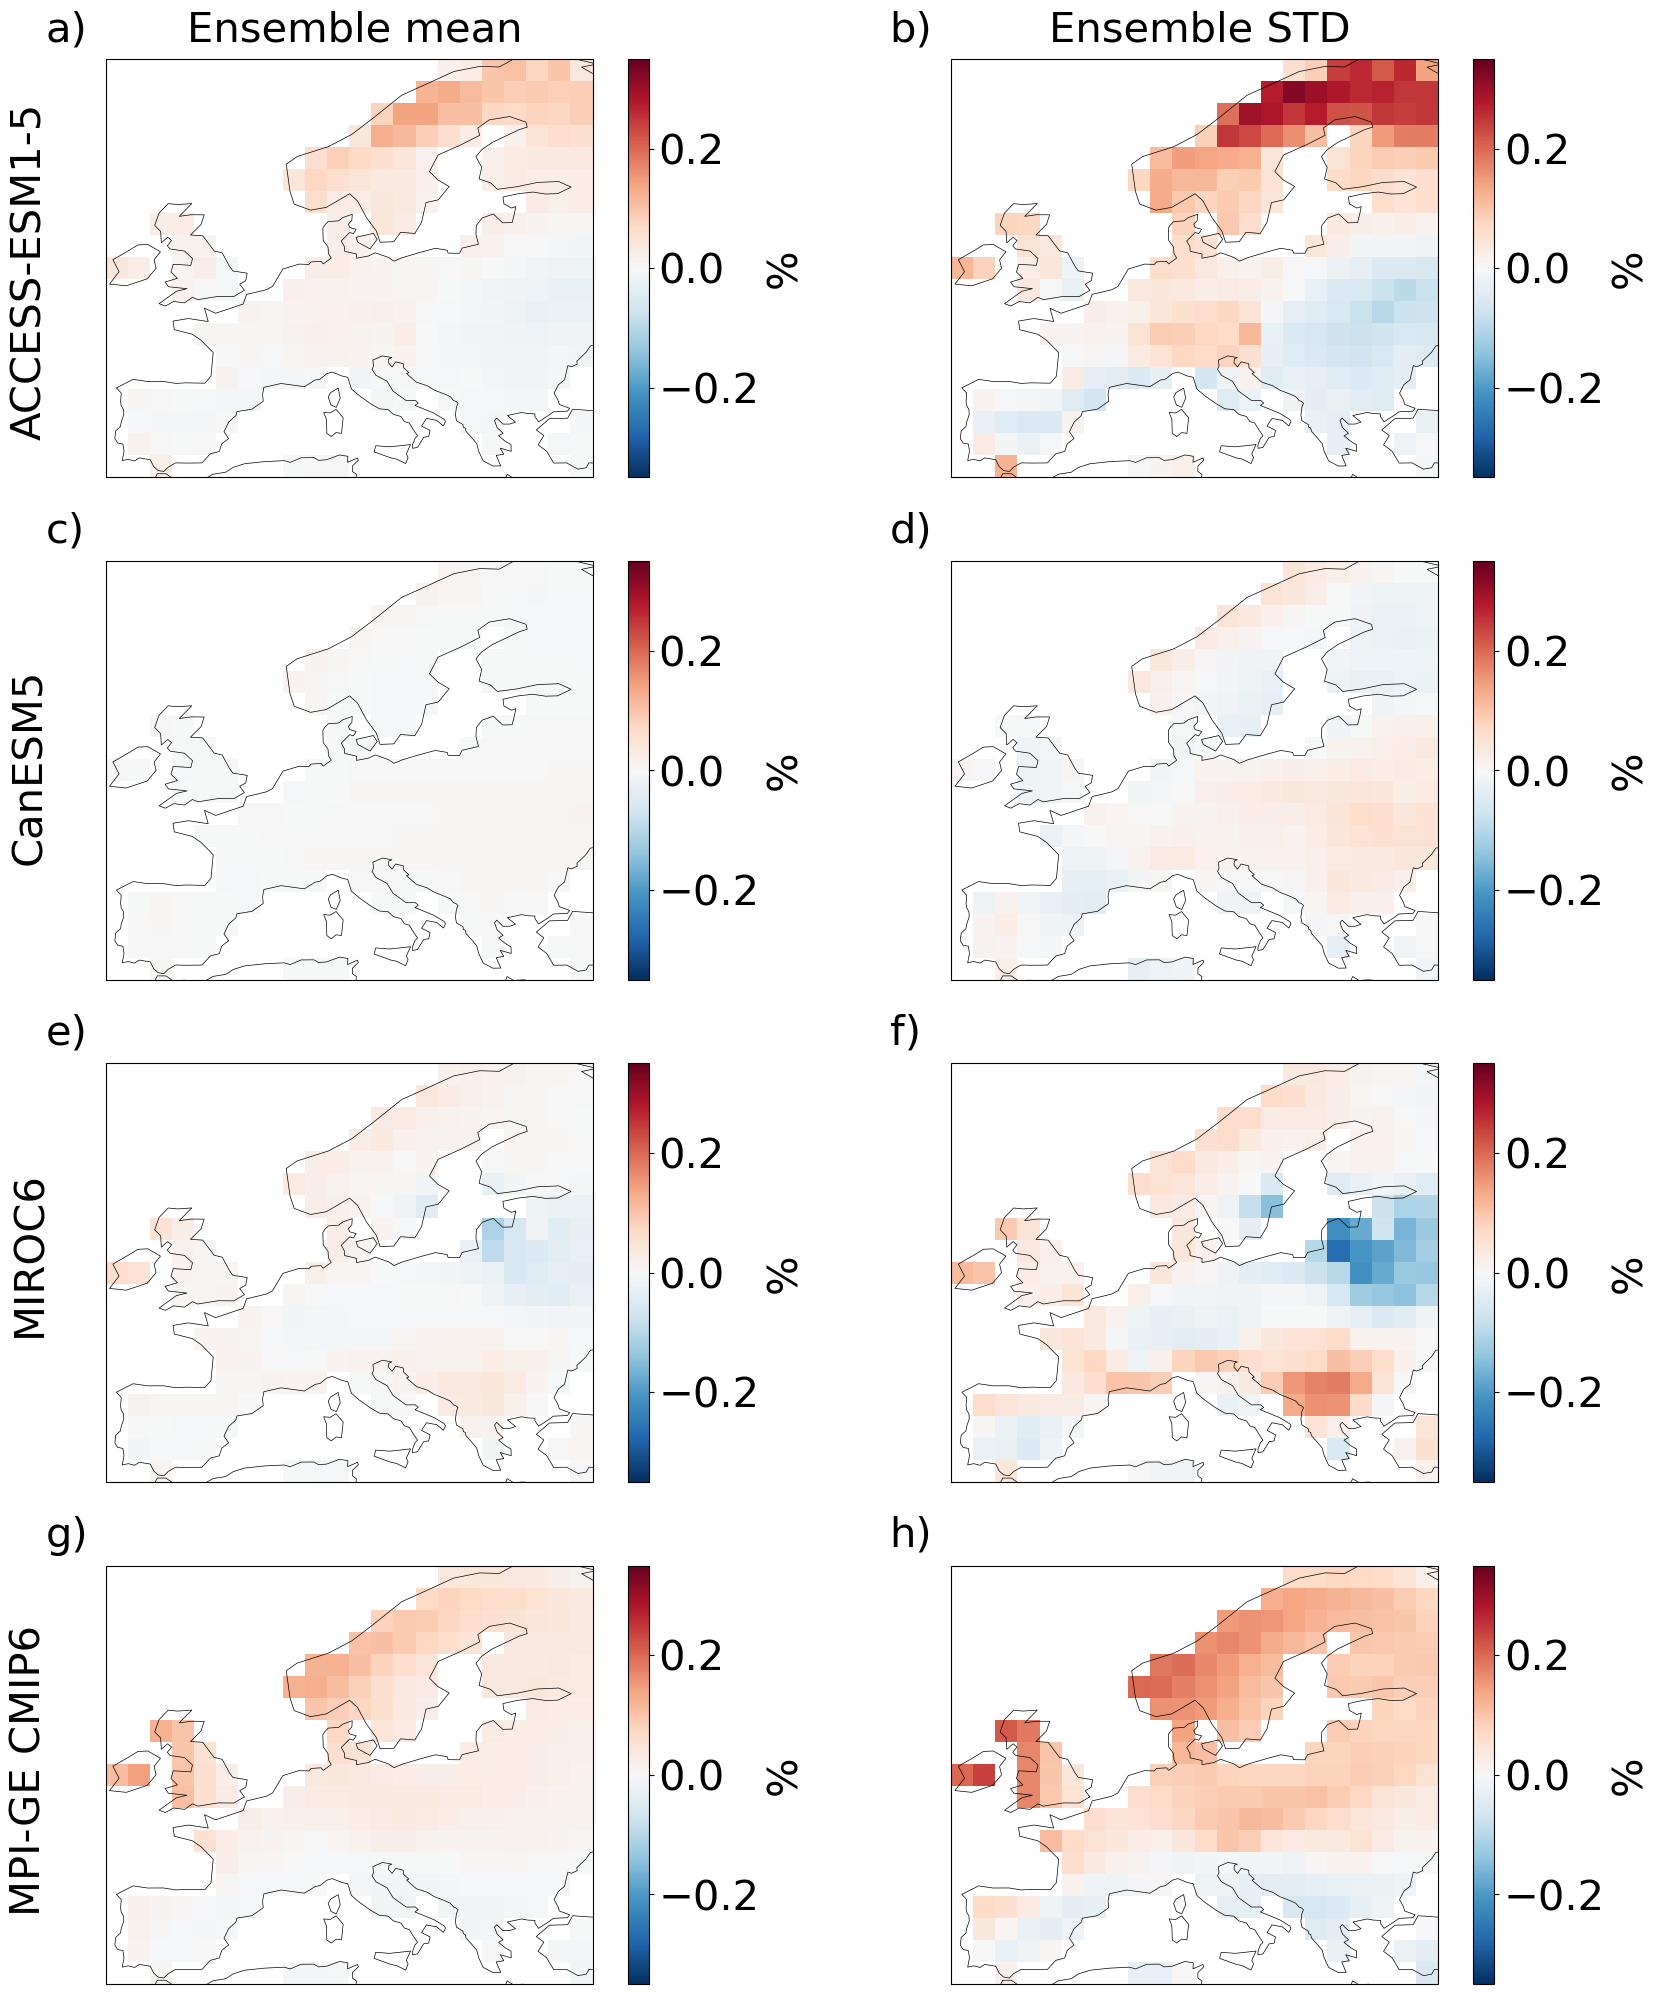

In [19]:
fig = plt.figure(figsize=(20,25))
plt.rcParams.update({'font.size': 30})
v_max = 0.35
v_min = -v_max

ax = fig.add_subplot(4,2,1, projection=ccrs.PlateCarree())
plt.pcolormesh(mask_eu.lon,mask_eu.lat,lin_regres_GMTA_exceed_mean_gp_ratio_access,cmap=plt.cm.get_cmap('RdBu_r'),vmin=v_min,vmax=v_max)
plt.pcolor(mask_eu.lon,mask_eu.lat,hatch_mean_access,hatch='/',cmap=plt.cm.get_cmap('RdBu_r'),vmin=v_min,vmax=v_max)
plt.colorbar(label='%')
ax.coastlines(resolution='110m',lw=0.5,color='k'); ax.set_facecolor('w')
#plt.title('mean')

ax = fig.add_subplot(4,2,2, projection=ccrs.PlateCarree())
plt.pcolormesh(mask_eu.lon,mask_eu.lat,lin_regres_GMTA_exceed_std_ratio_access,cmap=plt.cm.get_cmap('RdBu_r'),vmin=v_min,vmax=v_max)
plt.pcolor(mask_eu.lon,mask_eu.lat,hatch_std_access,hatch='/',cmap=plt.cm.get_cmap('RdBu_r'),vmin=v_min,vmax=v_max)
plt.colorbar(label='%')
ax.coastlines(resolution='110m',lw=0.5,color='k'); ax.set_facecolor('w')
#plt.title('std')

ax = fig.add_subplot(4,2,3, projection=ccrs.PlateCarree())
plt.pcolormesh(mask_eu.lon,mask_eu.lat,lin_regres_GMTA_exceed_mean_gp_ratio_canesm,cmap=plt.cm.get_cmap('RdBu_r'),vmin=v_min,vmax=v_max)
plt.pcolor(mask_eu.lon,mask_eu.lat,hatch_mean_canesm,hatch='/',cmap=plt.cm.get_cmap('RdBu_r'),vmin=v_min,vmax=v_max)
plt.colorbar(label='%')
ax.coastlines(resolution='110m',lw=0.5,color='k'); ax.set_facecolor('w')
#plt.title('mean')

ax = fig.add_subplot(4,2,4, projection=ccrs.PlateCarree())
plt.pcolormesh(mask_eu.lon,mask_eu.lat,lin_regres_GMTA_exceed_std_ratio_canesm,cmap=plt.cm.get_cmap('RdBu_r'),vmin=v_min,vmax=v_max)
plt.pcolor(mask_eu.lon,mask_eu.lat,hatch_std_canesm,hatch='/',cmap=plt.cm.get_cmap('RdBu_r'),vmin=v_min,vmax=v_max)
plt.colorbar(label='%')
ax.coastlines(resolution='110m',lw=0.5,color='k'); ax.set_facecolor('w')
#plt.title('std')

ax = fig.add_subplot(4,2,5, projection=ccrs.PlateCarree())
plt.pcolormesh(mask_eu.lon,mask_eu.lat,lin_regres_GMTA_exceed_mean_gp_ratio_miroc,cmap=plt.cm.get_cmap('RdBu_r'),vmin=v_min,vmax=v_max)
plt.pcolor(mask_eu.lon,mask_eu.lat,hatch_mean_miroc,hatch='/',cmap=plt.cm.get_cmap('RdBu_r'),vmin=v_min,vmax=v_max)
plt.colorbar(label='%')
ax.coastlines(resolution='110m',lw=0.5,color='k'); ax.set_facecolor('w')
#plt.title('mean')

ax = fig.add_subplot(4,2,6, projection=ccrs.PlateCarree())
plt.pcolormesh(mask_eu.lon,mask_eu.lat,lin_regres_GMTA_exceed_std_ratio_miroc,cmap=plt.cm.get_cmap('RdBu_r'),vmin=v_min,vmax=v_max)
plt.pcolor(mask_eu.lon,mask_eu.lat,hatch_std_miroc,hatch='/',cmap=plt.cm.get_cmap('RdBu_r'),vmin=v_min,vmax=v_max)
plt.colorbar(label='%')
ax.coastlines(resolution='110m',lw=0.5,color='k'); ax.set_facecolor('w')
#plt.title('std')

ax = fig.add_subplot(4,2,7, projection=ccrs.PlateCarree())
plt.pcolormesh(mask_eu.lon,mask_eu.lat,lin_regres_GMTA_exceed_mean_gp_ratio_mpi,cmap=plt.cm.get_cmap('RdBu_r'),vmin=v_min,vmax=v_max)
plt.pcolor(mask_eu.lon,mask_eu.lat,hatch_mean_mpi,hatch='/',cmap=plt.cm.get_cmap('RdBu_r'),vmin=v_min,vmax=v_max)
plt.colorbar(label='%')
ax.coastlines(resolution='110m',lw=0.5,color='k'); ax.set_facecolor('w')
#plt.title('mean')

ax = fig.add_subplot(4,2,8, projection=ccrs.PlateCarree())
plt.pcolormesh(mask_eu.lon,mask_eu.lat,lin_regres_GMTA_exceed_std_ratio_mpi,cmap=plt.cm.get_cmap('RdBu_r'),vmin=v_min,vmax=v_max)
plt.pcolor(mask_eu.lon,mask_eu.lat,hatch_std_mpi,hatch='/',cmap=plt.cm.get_cmap('RdBu_r'),vmin=v_min,vmax=v_max)
plt.colorbar(label='%')
ax.coastlines(resolution='110m',lw=0.5,color='k'); ax.set_facecolor('w')
#plt.title('std')

#model names
plt.text(-90,167,'ACCESS-ESM1-5',rotation='vertical')
plt.text(-90,131,'CanESM5',rotation='vertical')
plt.text(-90,91,'MIROC6',rotation='vertical')
plt.text(-90,42,'MPI-GE CMIP6',rotation='vertical')

plt.text(-75,200,'Ensemble mean')
plt.text(-2,200,'Ensemble STD')

plt.text(-87,200,'a)')
plt.text(-15.5,200,'b)')
plt.text(-87,157.5,'c)')
plt.text(-15.5,157.5,'d)')
plt.text(-87,115,'e)')
plt.text(-15.5,115,'f)')
plt.text(-87,72.5,'g)')
plt.text(-15.5,72.5,'h)')

plt.savefig(plot_path + 'FINAL_SMILE_appendix_4',bbox_inches="tight",dpi=300) #dpi=600)

In [15]:
print('ACCESS:')
print('Mean ratio (max-min): %2.2f - %2.2f'%(np.nanmax(lin_regres_GMTA_exceed_mean_gp_ratio_access),np.nanmin(lin_regres_GMTA_exceed_mean_gp_ratio_access)))
print('STD ratio (max-min): %2.2f - %2.2f'%(np.nanmax(lin_regres_GMTA_exceed_std_ratio_access),np.nanmin(lin_regres_GMTA_exceed_std_ratio_access)))

print('Canesm:')
print('Mean ratio (max-min): %2.2f - %2.2f'%(np.nanmax(lin_regres_GMTA_exceed_mean_gp_ratio_canesm),np.nanmin(lin_regres_GMTA_exceed_mean_gp_ratio_canesm)))
print('STD ratio (max-min): %2.2f - %2.2f'%(np.nanmax(lin_regres_GMTA_exceed_std_ratio_canesm),np.nanmin(lin_regres_GMTA_exceed_std_ratio_canesm)))

print('Miroc:')
print('Mean ratio (max-min): %2.2f - %2.2f'%(np.nanmax(lin_regres_GMTA_exceed_mean_gp_ratio_miroc),np.nanmin(lin_regres_GMTA_exceed_mean_gp_ratio_miroc)))
print('STD ratio (max-min): %2.2f - %2.2f'%(np.nanmax(lin_regres_GMTA_exceed_std_ratio_miroc),np.nanmin(lin_regres_GMTA_exceed_std_ratio_miroc)))

print('MPI:')
print('Mean ratio (max-min): %2.2f - %2.2f'%(np.nanmax(lin_regres_GMTA_exceed_mean_gp_ratio_mpi),np.nanmin(lin_regres_GMTA_exceed_mean_gp_ratio_mpi)))
print('STD ratio (max-min): %2.2f - %2.2f'%(np.nanmax(lin_regres_GMTA_exceed_std_ratio_mpi),np.nanmin(lin_regres_GMTA_exceed_std_ratio_mpi)))

ACCESS:
Mean ratio (max-min): 0.14 - -0.03
STD ratio (max-min): 0.32 - -0.10
Canesm:
Mean ratio (max-min): 0.01 - -0.01
STD ratio (max-min): 0.06 - -0.04
Miroc:
Mean ratio (max-min): 0.07 - -0.11
STD ratio (max-min): 0.18 - -0.27
MPI:
Mean ratio (max-min): 0.14 - -0.01
STD ratio (max-min): 0.24 - -0.06
